# Cleaning: BNP01


This script cleans the data both by abnormal trials and by noisy channels and epileptic activity.


### Prep

In [32]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

In [2]:
%matplotlib qt5

In [33]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time, duration        

In [34]:
## Prep paths ##

subject = 'BNP01B'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [35]:
## Load Data ##

# raw_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_ieeg.fif")

info = mne.create_info(ch_names = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4', 'Stim'],
                       sfreq = 250,
                       ch_types = ['seeg', 'seeg', 'seeg', 'seeg', 'stim'])

raw_array = mne.io.Raw(f"{raw_data_dir}/ieeg/neuropace_BNP01B_raw.fif")
raw_fif = mne.io.RawArray(raw_array.get_data(), info)


Opening raw data file /home/brooke/pacman/raw_data/BNP01B/ieeg/neuropace_BNP01B_raw.fif...
Isotrak not found
    Range : 0 ... 268499 =      0.000 ...  1073.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=268500
    Range : 0 ... 268499 =      0.000 ...  1073.996 secs
Ready.


In [36]:
raw_fif

<RawArray | 5 x 268500 (1074.0 s), ~10.3 MB, data loaded>

In [39]:
## Filtering ##

# load data #
raw_fif.load_data()

# highpass filter @ 1 and lowpass @ 200 #
filtered_data = raw_fif.filter(l_freq=1, h_freq=124) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



In [40]:
## Load/Save Filtered Data ##

# # save #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif", overwrite = True)

# # load #
filtered_notch_data = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif")
events = mne.find_events(filtered_notch_data, output='step', min_duration =0.001, shortest_event = 1, consecutive = False, stim_channel='Stim')

Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BNP01B/ieeg/BNP01B_notched_filtered_ieeg.fif
Closing /home/brooke/pacman/raw_data/BNP01B/ieeg/BNP01B_notched_filtered_ieeg.fif
[done]
Opening raw data file /home/brooke/pacman/raw_data/BNP01B/ieeg/BNP01B_notched_filtered_ieeg.fif...
Isotrak not found
    Range : 0 ... 268499 =      0.000 ...  1073.996 secs
Ready.
Trigger channel has a non-zero initial value of 500 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
746 events found
Event IDs: [  0 300 500]


/tmp/ipykernel_18815/3891442346.py:8: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(filtered_notch_data, output='step', min_duration =0.001, shortest_event = 1, consecutive = False, stim_channel='Stim')


In [41]:
events

array([[  2101,      0,    300],
       [  2102,    300,      0],
       [  4651,      0,    300],
       ...,
       [268074,    300,      0],
       [268376,      0,    500],
       [268377,    500,      0]])

## Cleaning Neural Data

#### Bad Channels

Epileptic channels from my cleaning: 'LHip1 - LHip2', 'RHip1 - RHip2'


In [42]:
# Remove Channels from filtered data
bob_cleaned_bad_channels = ['LHip1 - LHip2', 'RHip1 - RHip2']
raw_fif.info['bads'].extend(bob_cleaned_bad_channels)  


bob_cleaned_bad_channels = ['LHip1 - LHip2', 'RHip1 - RHip2']
filtered_notch_data.info['bads'].extend(bob_cleaned_bad_channels)  


#### Bad Epochs



## Cleaning Bad Trials

In [44]:
# # Annotate Noisy Epochs from Bob's cleaning

#read from csv from interactive session
bad_annots = mne.read_annotations('../ieeg/saved_annotations.fif')   


#### Bad epochs from bad trial data

In [66]:
# ## quality check trials ##

# calculate trial onsets and offsets
sti_raw = filtered_notch_data.get_data(picks = ['stim'])
lengths, positionsm, val  = rle(sti_raw[0])

# lengths, beginnings, endings, for trials
trial_begins = [positionsm[x] for x in np.where(val == 300)]
trial_ends = [positionsm[x] for x in np.where(val == -300)]
trial_lengths = [trial_ends[x] - trial_begins[x] for x in range(len(trial_begins))]

# save trial lengths for later
np.save(f"{preproc_data_dir}/{subject}_trial_lengths.npy", trial_lengths)

In [77]:
# # exclude bad trials/apochs from r behavioral analysis (paused trials and no biscuits)

# load bad trial data
bad_trials = np.genfromtxt(f"{raw_data_dir}/behave/{subject}_bad_trials.csv", delimiter = ',', skip_header = 1)
bad_trials = [x for x in bad_trials if x < 180] # we lost signal after 9th block

onsets = []
durations = []
for bad in bad_trials:
    start, dur = find_bad_trial_times(int(bad), raw_fif.info['sfreq'], trial_begins, trial_lengths)
    onsets.append(start)
    durations.append(dur)

# update descriptions
descriptions = ['bad'] * len(durations)


57.0
125.0
145.0
167.0
179.0
0.0


In [78]:
## exclude all bad epochs from both bad trials and investigating neural data ##

# combine with bad trial data #
bad_annots.append(onsets, durations, descriptions)

# # apply to filtered data #
filtered_notch_data.set_annotations(bad_annots)

# # apply to not filtered data #
raw_fif.set_annotations(bad_annots)

<RawArray | 5 x 268500 (1074.0 s), ~10.3 MB, data loaded>

## Visualizing Neural Data

next step, working on filtering out the high frequency noise

then look at Marks script to come up with some plot of every trial, sort longest to shortest, with theta power as the color tiome as x, trial on y

Opening raw-browser...


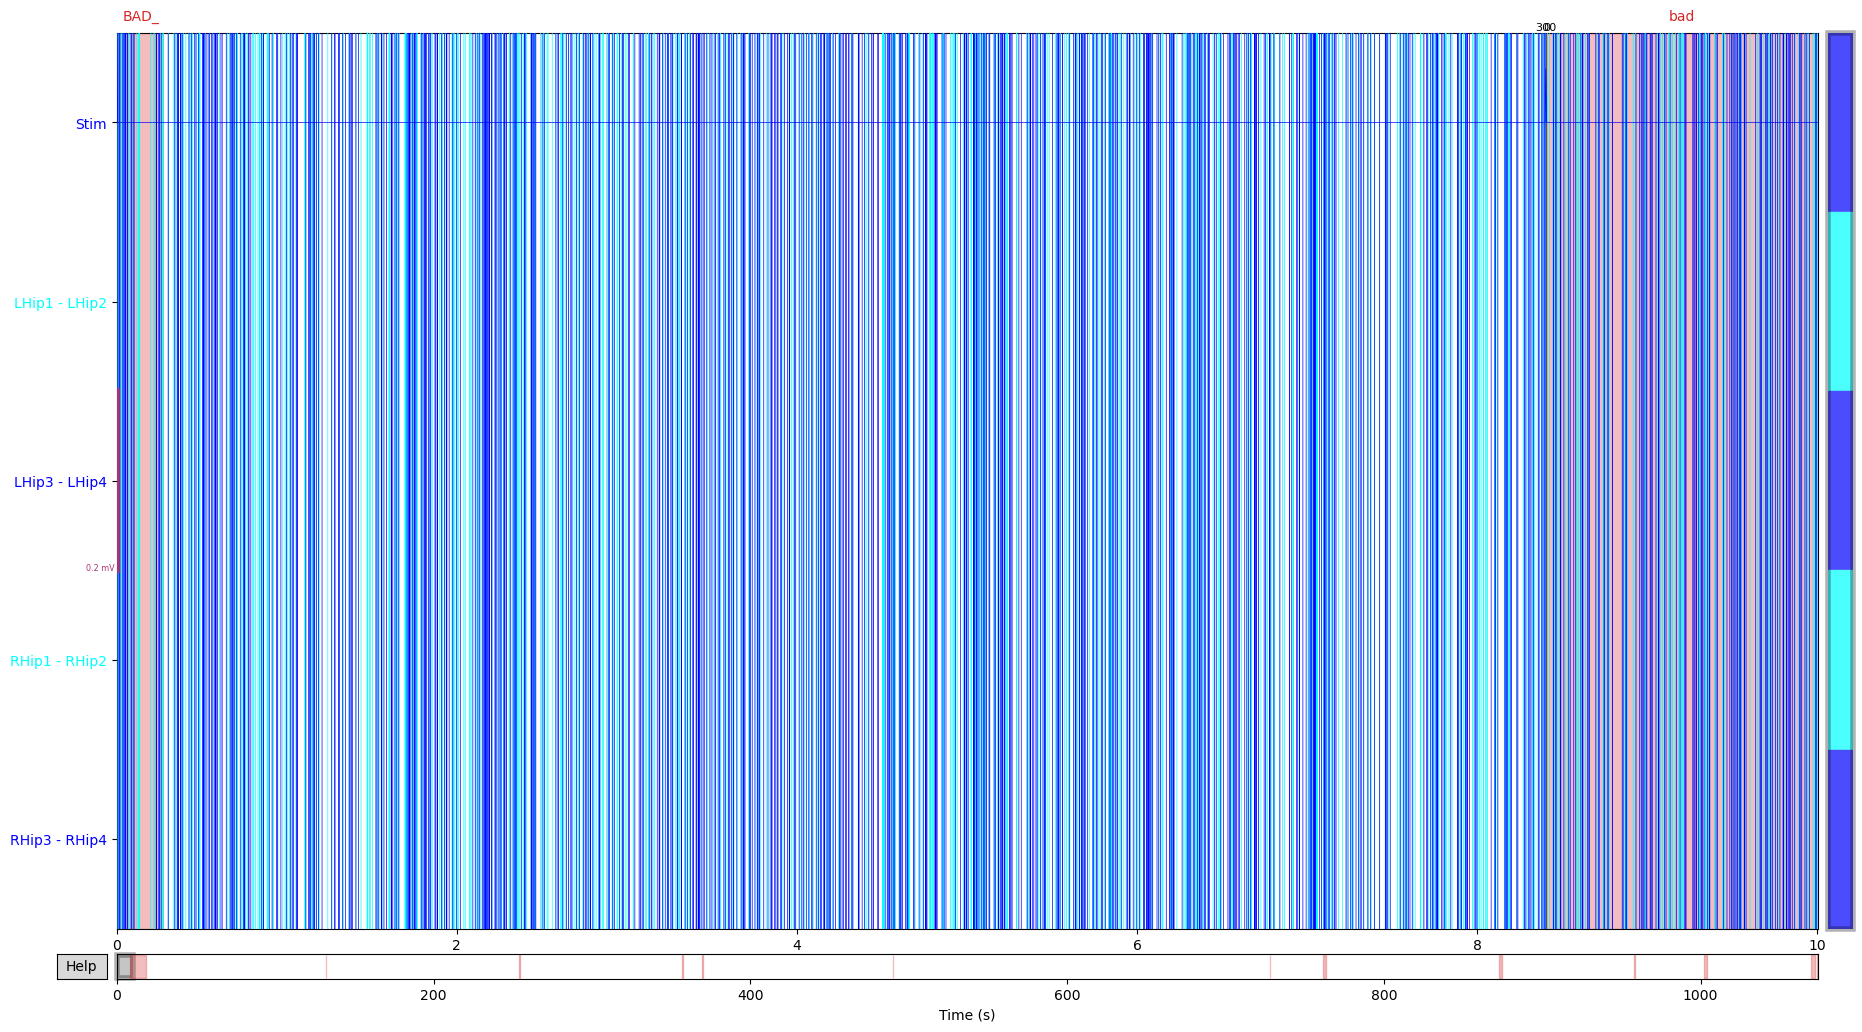

In [79]:
# plot for cleaning #

filtered_notch_data.plot(events = events, color='b', bad_color = 'cyan', n_channels = 230, clipping = None, event_color = 'r')

Setting 5446 of 268500 (2.03%) samples to NaN, retaining 263054 (97.97%) samples.
Effective window size : 8.192 (s)


/tmp/ipykernel_18815/3671565419.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_notch_data.plot_psd()


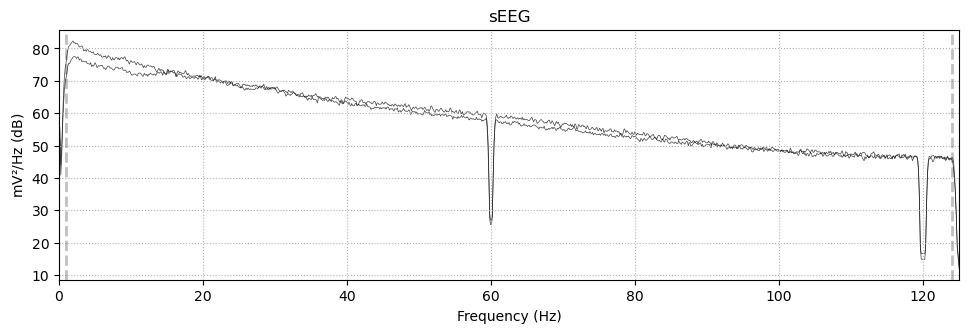

In [80]:
# plot psd of all channels #

filtered_notch_data.plot_psd()

In [27]:
filtered_notch_data.annotations

<Annotations | 8 segments: BAD_ (8)>

In [29]:
# From interactive sessions
# interactive_annot = filtered_notch_data.annotations
# for x in range(0, 8):
#     print(interactive_annot[x])
    
    
# filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True)    

OrderedDict([('onset', 0.01176249265138174), ('duration', 0.25877483833039383), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 131.88788007054674), ('duration', 0.34699353321573767), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 253.7051851851852), ('duration', 0.5587184009406201), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 369.6280705467372), ('duration', 0.5704808935920482), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 489.75157671957675), ('duration', 0.28818106995885273), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 727.9813215755437), ('duration', 0.041168724279827984), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 957.957796590241), ('duration', 0.37051851851856554), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 1073.4904150499706), ('duration', 0.4879482657261178), ('description', 'BAD_'), ('orig_time', None)]

/tmp/ipykernel_18815/3128295839.py:7: RuntimeWarning: This filename (../ieeg/saved_annotations.fif) does not conform to MNE naming conventions. All annotations files should end with -annot.fif, -annot.fif.gz, _annot.fif, _annot.fif.gz, .txt or .csv
  filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True)


## Save Files

In [81]:
# save filtered data #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif", overwrite = True)


# save raw clean data #
raw_fif.save(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BNP01B/ieeg/BNP01B_notched_filtered_clean_ieeg.fif
Closing /home/brooke/pacman/raw_data/BNP01B/ieeg/BNP01B_notched_filtered_clean_ieeg.fif
[done]
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BNP01B/ieeg/BNP01B_raw_clean_ieeg.fif
Closing /home/brooke/pacman/raw_data/BNP01B/ieeg/BNP01B_raw_clean_ieeg.fif
[done]
